# Sobol indices

In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Gaussian Framework

In [2]:
from shapley.tests import AdditiveGaussian
dim = 3
beta = None
model = AdditiveGaussian(dim, beta)

### Monte-Carlo estimation using true model

In [3]:
%%time
from shapley import SobolIndices

ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_sample = 500

sobol = SobolIndices(model.input_distribution)

# Generate the samples
sobol.build_sample(model=model, n_sample=n_sample)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 539 ms


In [4]:
%%time
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

n_boot = 500
estimator = 'sobolmara'

# Indice estimation
sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)

CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 140 ms


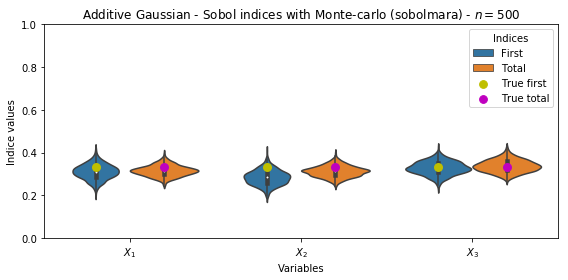

In [5]:
from shapley.plots import plot_sensitivity_results

ylim = [0., 1.]

fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_results, ax=ax)
ax.set_title("%s - Sobol indices with Monte-carlo (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Kriging model

In [9]:
from shapley.kriging import KrigingModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_budget = 15
sampling = 'lhs'
library = 'sklearn'
kernel = 'matern'
basis = 'linear'

model_gp = KrigingModel(model=model, input_distribution=model.input_distribution)
model_gp.generate_sample(n_sample=model_budget, sampling=sampling)
model_gp.build(library=library, kernel=kernel, basis_type=basis)

In [10]:
# The score of the meta_model
q2_score_cv_gp = model_gp.compute_score_q2_cv(n_sample=10000)
print('Q2-score by cross-validation:', q2_score_cv_gp)

Q2-score by cross-validation: 0.931684152236


In [ ]:
%%time
n_realization = 500
sobol.build_sample(model=model_gp, n_sample=n_sample, n_realization=n_realization)

CPU times: user 5min 44s, sys: 5.76 s, total: 5min 50s
Wall time: 50.8 s


In [ ]:
%%time
# Indice estimation
sobol_gp_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)

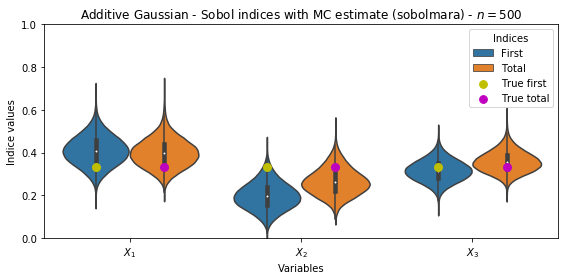

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_gp_results, ax=ax)
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

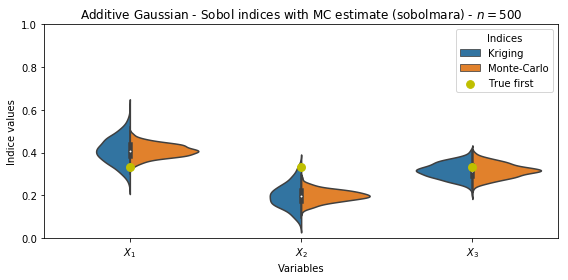

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_gp_results, ax=ax, indice='first')
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

### Monte-Carlo estimation using a Random Forest model

In [13]:
from shapley.forest import RandomForestModel
ot.RandomGenerator.SetSeed(0)
np.random.seed(0)

model_rf = RandomForestModel(model=model, input_distribution=model.input_distribution)
model_rf.generate_sample(n_sample=model_budget, sampling=sampling)
model_rf.build(n_realization)

In [14]:
# The score of the meta_model
q2_score_cv_rf = model_rf.compute_score_q2_cv(n_sample=10000)
print('Q2-score by cross-validation:', q2_score_cv_rf)

Q2-score by cross-validation: 0.621246586676


In [15]:
%%time
sobol.build_sample(model_rf, n_sample=n_sample, n_realization=n_realization)

CPU times: user 280 ms, sys: 4 ms, total: 284 ms
Wall time: 283 ms


In [17]:
%%time
# Indice estimation
sobol_rf_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator)

There is no true first order sobol indices
There is no true total sobol indices
There is no true shapley indices.
CPU times: user 6.83 s, sys: 7.48 s, total: 14.3 s
Wall time: 14.4 s


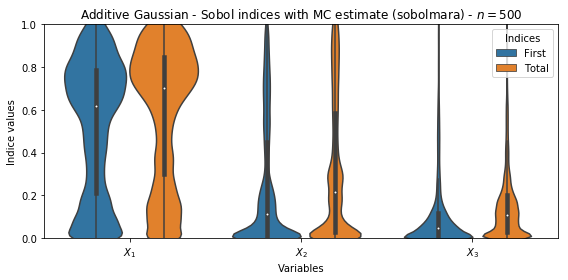

In [18]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_rf_results, ax=ax)
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()

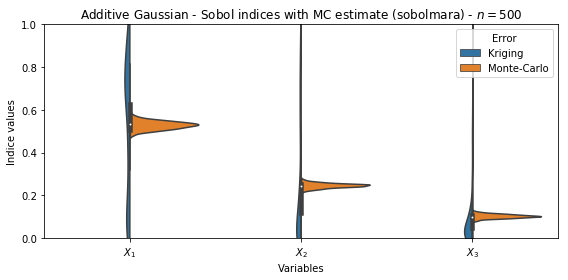

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
plot_sensitivity_results(sobol_rf_results, ax=ax, indice='first')
ax.set_title("%s - Sobol indices with MC estimate (%s) - $n=%d$" % (model.name, estimator, n_sample))
ax.set_ylim(ylim)
fig.tight_layout()